__POS__

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from time import time

In [3]:
from sklearn.svm import LinearSVC, SVC
from sklearn import decomposition
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler

In [4]:
def split_train_test_data(input_data, target, ratio=0.3, rand_state=42):
    return train_test_split(input_data, target, test_size=ratio, stratify=target, random_state=rand_state)

def apply_grid_search_cv(pipe, param_grid, X_train, y_train, X_test, y_test, print_flag=True, score_matrix=f1_score, n_jobs=-1, cv=5):
    grid_search = GridSearchCV(pipe, param_grid=param_grid, scoring=make_scorer(score_matrix), n_jobs=n_jobs, cv=cv)
    t0 = time()
    res = grid_search.fit(X_train, y_train)
    if print_flag:
        print("done in %0.3fs" % (time() - t0))
        print("best params:")
        print(res.best_params_)
        print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
        print("Test-set score: {:.3f}".format(grid_search.score(X_test, y_test)))        
    return grid_search

def save_class_report_cv(grid_search, X_test, y_test, target_names, filename):
    y_pred = grid_search.best_estimator_.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df.to_csv(filename)
    return df

In [5]:
def save_cross_validation_results(grid_search, filename, print_flag=True):
    param_keys = list(grid_search.cv_results_["params"][0].keys())
    matrix_list = ["mean_test_score", "std_test_score", "rank_test_score", "mean_fit_time"] 
    col = param_keys + matrix_list

    cv_results = []
    cv_results.append(col)    
    
    for param, score, std, rank, time in zip(grid_search.cv_results_["params"], grid_search.cv_results_["mean_test_score"],grid_search.cv_results_["std_test_score"],
                                             grid_search.cv_results_["rank_test_score"], grid_search.cv_results_["mean_fit_time"]):
        row_item = list(param.values())
        row_item.append(score)
        row_item.append(std)
        row_item.append(rank)
        row_item.append(time)
        cv_results.append(row_item)
        
    cv_results = pd.DataFrame(cv_results) 
    header = cv_results.iloc[0] 
    cv_results = cv_results[1:]
    cv_results = cv_results.rename(columns = header)
    cv_results = cv_results.sort_values(by=['rank_test_score'])
    cv_results.to_csv(filename)
    if print_flag:
        print(cv_results.head(6))
#        print(cv_results.tail(6))

In [6]:
hotels = pd .read_csv("data/LIWC2015_mod5.csv")

In [7]:
pd.set_option('display.max_columns', 500)

In [8]:
hotels = hotels.drop(hotels.columns[0], axis=1)

In [9]:
hotels.describe(include="all")

,deceptive,hotel,polarity,source,text,text_length,lower_case,lc_no_punct,norm,norm_lemma,norm_stem,norm_lemma_stopword,norm_stem_stopword,ADJ_count,ADP_count,ADV_count,AUX_count,CCONJ_count,DET_count,INTJ_count,NOUN_count,NUM_count,PART_count,PRON_count,PROPN_count,PUNCT_count,SCONJ_count,SYM_count,VERB_count,X_count,class,WC,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,affect,posemo,negemo,anx,anger,sad,social,family,friend,female,male,cogproc,insight,cause,discrep,tentat,certain,differ,percept,see,hear,feel,bio,body,health,sexual,ingest,drives,affiliation,achieve,power,reward,risk,focuspast,focuspresent,focusfuture,relativ,motion,space,time,work,leisure,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler,AllPunc,Period,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
count,1600.000000,1600,1600.000000,1600,1600,1600.000000,1600,1600,1600,1600,1600,1600,1600,1600.000000,1600.000000,1600.000000,1600.0,1600.0,1600.000000,1600.0,1600.000000,1600.000000,1600.0,1600.000000,1600.0,1600.0,1600.0,1600.0,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.00000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.00000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.00000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.0,1600.000000,1600.000000,1600.000000
unique,NaN,20,NaN,3,1596,NaN,1596,1596,1596,1596,1596,1596,1596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,talbott,NaN,MTurk,"I'd been searching for a cool, non-chain hotel...",NaN,very disappointed in our stay in chicago monoc...,very disappointed in our stay in chicago monoc...,very disappointed in our stay in chicago monoc...,i d be search for a cool non chain hotel for a...,the omni wa chosen for it s locat whichwork ou...,disappointed stay chicago monoco stay ma...,daughter woke morn want go swim arriv ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,80,NaN,800,2,NaN,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [10]:
pos = hotels.loc[:, "ADJ_count":"X_count"]

In [11]:
pos.head(2)

,ADJ_count,ADP_count,ADV_count,AUX_count,CCONJ_count,DET_count,INTJ_count,NOUN_count,NUM_count,PART_count,PRON_count,PROPN_count,PUNCT_count,SCONJ_count,SYM_count,VERB_count,X_count
0,0.148148,0.120370,0.074074,0,0,0.101852,0,0.277778,0.064815,0,0.037037,0,0,0,0,0.129630,0.0
1,0.136364,0.113636,0.068182,0,0,0.090909,0,0.318182,0.022727,0,0.000000,0,0,0,0,0.227273,0.0


In [12]:
pos.columns

Index(['ADJ_count', 'ADP_count', 'ADV_count', 'AUX_count', 'CCONJ_count',
       'DET_count', 'INTJ_count', 'NOUN_count', 'NUM_count', 'PART_count',
       'PRON_count', 'PROPN_count', 'PUNCT_count', 'SCONJ_count', 'SYM_count',
       'VERB_count', 'X_count'],
      dtype='object')

In [13]:
len(pos.columns)

17

__1. Choose input data and target__

In [14]:
X = pos

In [15]:
y = hotels["deceptive"]

__2. Split data__

In [16]:
X_train, X_test, y_train, y_test = split_train_test_data(X, y)

__3. Build pipeline__

In [17]:
steps_lr = [
    ('scale', StandardScaler()),
    ('clf', LogisticRegression()),
]

pipe_lr = Pipeline(steps_lr)

__4. Construct parameters for cross validation testing__

In [18]:
param_grid_lr = [
    {
         'clf__C': [0.001, 0.01, 0.1, 1, 10, 100]}
]

__5. Apply Grid Serach CV__

In [19]:
log_reg_grid_search = apply_grid_search_cv(pipe_lr, param_grid_lr, X_train, y_train, X_test, y_test)

done in 3.254s
best params:
{'clf__C': 0.01}
Best cross-validation score: 0.693
Test-set score: 0.673


C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


__6. Save Classification Report to File__

In [20]:
save_class_report_cv(log_reg_grid_search, X_test, y_test, ["truthful", "deceptive"], "output/log_reg_pos1_report.csv")

C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


,f1-score,precision,recall,support
truthful,0.618510,0.674877,0.570833,240.0
deceptive,0.673114,0.628159,0.725000,240.0
micro avg,0.647917,0.647917,0.647917,480.0
macro avg,0.645812,0.651518,0.647917,480.0
weighted avg,0.645812,0.651518,0.647917,480.0


In [21]:
save_cross_validation_results(log_reg_grid_search, "output/log_reg_pos1_validation_res.csv", True)

  clf__C mean_test_score std_test_score rank_test_score mean_fit_time
2   0.01        0.693191      0.0057881               1     0.0113692
3    0.1         0.68871     0.00565216               2    0.00977316
4      1        0.688162     0.00646212               3    0.00917616
5     10        0.688162     0.00646212               3    0.00937433
6    100        0.688162     0.00646212               3    0.00937481
1  0.001        0.675549       0.020399               6     0.0233385


__7. Save model to file__

In [22]:
from sklearn.externals import joblib
joblib.dump(log_reg_grid_search.best_estimator_, 'output/log_reg_pos1.pkl')

['output/log_reg_pos1.pkl']

__7b. Identify important features for deceptive opinion spam__

In [23]:
scaler = log_reg_grid_search.best_estimator_.named_steps["scale"]

# transform the training dataset
X_train1 = scaler.transform(X_train)

max_value = X_train1.max(axis=0).ravel()
sorted_by_scale = max_value.argsort()

#feature_names = np.array(scaler.get_feature_names())
feature_names = X_train.columns

print("Features with lowest scaled value:\n{}".format(
    feature_names[sorted_by_scale[:10]]))

print("Features with highest scaled value: \n{}".format(
    feature_names[sorted_by_scale[-10:]]))

Features with lowest scaled value:
Index(['AUX_count', 'CCONJ_count', 'INTJ_count', 'PART_count', 'PROPN_count',
       'PUNCT_count', 'SCONJ_count', 'SYM_count', 'ADP_count', 'VERB_count'],
      dtype='object')
Features with highest scaled value: 
Index(['SYM_count', 'ADP_count', 'VERB_count', 'PRON_count', 'DET_count',
       'NOUN_count', 'ADV_count', 'ADJ_count', 'NUM_count', 'X_count'],
      dtype='object')


C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


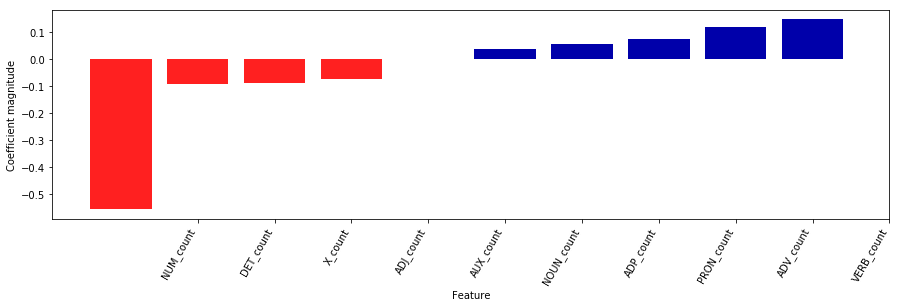

In [24]:
import mglearn

mglearn.tools.visualize_coefficients(
    log_reg_grid_search.best_estimator_.named_steps["clf"].coef_,
    feature_names, n_top_features=5)

__Observation:__ The negative coefficients on the left represent truthful reviews (as it is negative of the "deceptive" column) while the positive coefficients on the right represent the deceptive reviews. From here we can see that truthful reviews have more numerical values, determiners / articles and adjective. The deceptive reviews on the other hand have more verbs, adverbs, pronouns, adposition and nouns.

__8. Sentiment Analysis__

In [25]:
y = hotels["polarity"]
X_train, X_test, y_train, y_test = split_train_test_data(X, y)
log_reg_grid_search_p = apply_grid_search_cv(pipe_lr, param_grid_lr, X_train, y_train, X_test, y_test)

done in 0.239s
best params:
{'clf__C': 0.01}
Best cross-validation score: 0.704
Test-set score: 0.708


C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [26]:
save_cross_validation_results(log_reg_grid_search_p, "output/log_reg_pos_sent_validation_res.csv")

  clf__C mean_test_score std_test_score rank_test_score mean_fit_time
2   0.01        0.703667      0.0279262               1     0.0131663
4      1        0.702497      0.0324811               2     0.0137667
5     10        0.701797      0.0315768               3    0.00537796
6    100        0.701797      0.0315768               3    0.00897503
3    0.1        0.700162        0.02677               5     0.0209448
1  0.001        0.692006      0.0290417               6     0.0107713


In [27]:
save_class_report_cv(log_reg_grid_search_p, X_test, y_test, ["negative", "positive"], "output/log_reg_pos_report_sent.csv")

C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


,f1-score,precision,recall,support
negative,0.717213,0.705645,0.729167,240.0
positive,0.707627,0.719828,0.695833,240.0
micro avg,0.712500,0.712500,0.712500,480.0
macro avg,0.712420,0.712736,0.712500,480.0
weighted avg,0.712420,0.712736,0.712500,480.0


__8b. Identify important features for sentiment analysis__

In [28]:
scaler = log_reg_grid_search_p.best_estimator_.named_steps["scale"]

# transform the training dataset
X_train1 = scaler.transform(X_train)

max_value = X_train1.max(axis=0).ravel()
sorted_by_scale = max_value.argsort()

#feature_names = np.array(scaler.get_feature_names())
feature_names = X_train.columns

print("Features with lowest scaled value:\n{}".format(
    feature_names[sorted_by_scale[:10]]))

print("Features with highest scaled value: \n{}".format(
    feature_names[sorted_by_scale[-10:]]))

Features with lowest scaled value:
Index(['AUX_count', 'CCONJ_count', 'INTJ_count', 'PART_count', 'PROPN_count',
       'PUNCT_count', 'SCONJ_count', 'SYM_count', 'ADP_count', 'VERB_count'],
      dtype='object')
Features with highest scaled value: 
Index(['SYM_count', 'ADP_count', 'VERB_count', 'NOUN_count', 'DET_count',
       'ADV_count', 'ADJ_count', 'PRON_count', 'NUM_count', 'X_count'],
      dtype='object')


C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


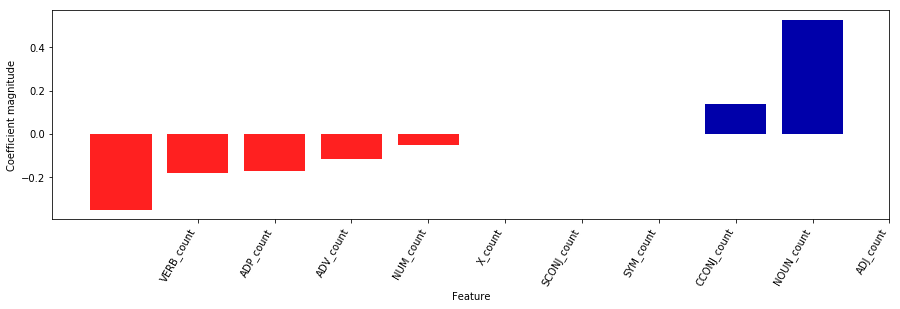

In [29]:
import mglearn

mglearn.tools.visualize_coefficients(
    log_reg_grid_search_p.best_estimator_.named_steps["clf"].coef_,
    feature_names, n_top_features=5)

__Observation:__ The negative coefficients on the left represent negative sentiments while the positive coefficients on the right represent positive sentiments. It appears that negative reviews contain more verb, adposition, advertbs and numbers while the positive reviews contain more adjectives and nouns.

***

__Combined TFIDF with POS Analysis__

In [30]:
hotels_comb = pd.concat([hotels["norm"], pos], axis=1)
hotels_comb.head(2)

,norm,ADJ_count,ADP_count,ADV_count,AUX_count,CCONJ_count,DET_count,INTJ_count,NOUN_count,NUM_count,PART_count,PRON_count,PROPN_count,PUNCT_count,SCONJ_count,SYM_count,VERB_count,X_count
0,we stayed for a one night getaway with family ...,0.148148,0.120370,0.074074,0,0,0.101852,0,0.277778,0.064815,0,0.037037,0,0,0,0,0.129630,0.0
1,triple a rate with upgrade to view room was le...,0.136364,0.113636,0.068182,0,0,0.090909,0,0.318182,0.022727,0,0.000000,0,0,0,0,0.227273,0.0


__1. Choose input data and target__

In [31]:
X = hotels_comb
y = hotels["deceptive"]

__2. Split data__

In [32]:
X_train, X_test, y_train, y_test = split_train_test_data(X, y)

__3. Build pipeline__

__4. Construct parameters for cross validation testing__

In [33]:
param_grid_lr_comb = [
    {
         'clf__C': [0.001, 0.01, 0.1, 1, 10, 100]}
]

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion

In [35]:
class ItemExcluder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_frame):
        #df = data_frame.loc[:, data_frame.columns != self.key]
        df = data_frame.drop([self.key], axis=1)
        return df
    
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_frame):
        df = data_frame[self.key]
        return df

In [36]:
steps_combined = [
    ('preprocess', FeatureUnion(
        transformer_list=[
            ('terms', Pipeline([
                ('selector', ItemSelector(key='norm')),
                ('vect', CountVectorizer()),                
                ('tfidf', TfidfTransformer())
            ])),
            ('pos', Pipeline([
                ('selector', ItemExcluder(key='norm')),
                ('scale', StandardScaler())
            ]))                        
        ]    
    )),        
    ('clf', LogisticRegression())
]

pipe_comb = Pipeline(steps_combined)

In [37]:
param_grid_comb = [
    {'preprocess__terms__vect__stop_words': ['english', None],
        'preprocess__terms__vect__min_df': [1, 2, 5], 
        'preprocess__terms__vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
         'clf__C': [0.1, 1, 10, 100, 1000]}
]

__5. Apply Grid Serach CV__

In [40]:
lr_pos_comb_grid_search = apply_grid_search_cv(pipe_comb, param_grid_comb, X_train, y_train, X_test, y_test)

C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


done in 76.269s
best params:
{'clf__C': 1000, 'preprocess__terms__vect__min_df': 2, 'preprocess__terms__vect__ngram_range': (1, 2), 'preprocess__terms__vect__stop_words': None}
Best cross-validation score: 0.867
Test-set score: 0.877


C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


__6. Save Reports to File__

In [41]:
save_cross_validation_results(lr_pos_comb_grid_search, "output/lr_pos_comb1_validation_res.csv", True)

   clf__C preprocess__terms__vect__min_df  \
82   1000                               2   
79   1000                               2   
64    100                               2   
73   1000                               1   
84   1000                               2   
81   1000                               2   

   preprocess__terms__vect__ngram_range preprocess__terms__vect__stop_words  \
82                               (1, 2)                                None   
79                               (1, 1)                             english   
64                               (1, 2)                                None   
73                               (1, 1)                             english   
84                               (1, 3)                                None   
81                               (1, 2)                             english   

   mean_test_score std_test_score rank_test_score mean_fit_time  
82        0.867344       0.021772               1      0.983173 

__7. Save model to file__

In [42]:
save_class_report_cv(lr_pos_comb_grid_search, X_test, y_test, ["truthful", "deceptive"], "output/lr_pos_comb1_report.csv")

C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


,f1-score,precision,recall,support
truthful,0.868817,0.897778,0.841667,240.0
deceptive,0.876768,0.850980,0.904167,240.0
micro avg,0.872917,0.872917,0.872917,480.0
macro avg,0.872792,0.874379,0.872917,480.0
weighted avg,0.872792,0.874379,0.872917,480.0


__8. Sentiment__

In [43]:
y = hotels["polarity"]
X_train, X_test, y_train, y_test = split_train_test_data(X, y)
lr_pos_comb_grid_search_p = apply_grid_search_cv(pipe_comb, param_grid_comb, X_train, y_train, X_test, y_test)

done in 81.215s
best params:
{'clf__C': 1000, 'preprocess__terms__vect__min_df': 2, 'preprocess__terms__vect__ngram_range': (1, 1), 'preprocess__terms__vect__stop_words': None}
Best cross-validation score: 0.944
Test-set score: 0.951


C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [45]:
save_cross_validation_results(lr_pos_comb_grid_search_p, "output/lr_pos_comb1_validation_res_sent.csv", True)

   clf__C preprocess__terms__vect__min_df  \
80   1000                               2   
90   1000                               5   
62    100                               2   
70    100                               5   
88   1000                               5   
72    100                               5   

   preprocess__terms__vect__ngram_range preprocess__terms__vect__stop_words  \
80                               (1, 1)                                None   
90                               (1, 3)                                None   
62                               (1, 1)                                None   
70                               (1, 2)                                None   
88                               (1, 2)                                None   
72                               (1, 3)                                None   

   mean_test_score std_test_score rank_test_score mean_fit_time  
80        0.943601      0.0113388               1      0.418283 

In [44]:
save_class_report_cv(lr_pos_comb_grid_search_p, X_test, y_test, ["negative", "positive"], "output/lr_pos_comb1_report_sent.csv")

C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


,f1-score,precision,recall,support
negative,0.952965,0.935743,0.970833,240.0
positive,0.951168,0.969697,0.933333,240.0
micro avg,0.952083,0.952083,0.952083,480.0
macro avg,0.952066,0.952720,0.952083,480.0
weighted avg,0.952066,0.952720,0.952083,480.0
